<a href="https://www.kaggle.com/code/fahmirk/web-scraping-e-ipo-data-with-selenium?scriptVersionId=203791202" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

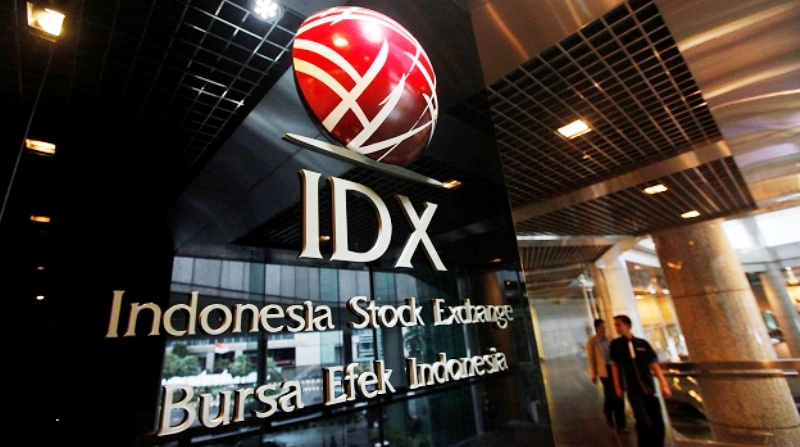<br>
<cite>Image from [m.cobisnis.com](https://m.cobisnis.com/tahun-2023-bei-targetkan-ipo-57-perusahaan)<cite>

**This notebook will explain how Chrome Driver and Selenium in Python can scrape data available on the e-IPO (Electronic Indonesia Public Offering) website in Realtime.**

### First, please **Upvote** this notebook if u like it :)

The notebook can be used to scrape all the company data available on the e-IPO website in real time, as long as the structure of the website is not changed (only the data of the company that is going to IPO is added).

**Notes**: If there is a change in the website structure, I may revise this notebook so that it can work properly.

**Disclaimer**: There may be any mistakes in this notebook because I'm not an expert, but I'm glad it works. Some of the sources I used in making this notebook are Kaggle and Stack Overflow. I am very happy if you make this as a reference. Please criticize and suggest.

**Update**:<br>
**5 August 2023**: The first **3 days return data** has been included in the dataset.<br>
**15 August 2023**: Dataset of **Listing Boards (Papan Pencatatan)** at the time of IPO available for each company code.<br>
**25 October 2023**: Return from Listing Date Data has been included in the dataset.<br>
**8 January 2024**: Listing board data is no longer retrieved manually from google spreadsheets using gdown, but uses direct access to the IDX website via selenium with proxy and undetected chromedriver. The web scraping process has been displayed in the form of a progress bar using the tqdm package.<br>
**10 January 2024**: Return data extended to the first 7 days return from 3 days return.<br>
**28 January 2024**: In addition to being exported into CSV, the dataset is also stored in google spreadsheet.<br>
**20 February 2024**: Code is optimized. First, the existing company data in the dataset is not retrieved from the website, so the scraping process only retrieves new company data. Second, minimizing the use of syntax time.sleep in the code and replacing it with function presence of element by XPATH.<br>
**25 April 2024**: Adding Warrant Data.<br>
**20 May 2024**: Change the source on the listing board data from the Stock List page (https://www.idx.co.id/id/data-pasar/data-saham/daftar-saham) to the List Activity page (https://www.idx.co.id/id/perusahaan-tercatat/aktivitas-pencatatan)

# Prerequisite

In [1]:
# System Update and Library Installation
# Update package lists and install necessary libraries for Chrome and Selenium
!apt-get update -y && apt-get install -y \
    libglib2.0-0 \
    libnss3 \
    libdbus-glib-1-2 \
    libgconf-2-4 \
    libfontconfig1 \
    gconf2-common \
    libwayland-server0 \
    libgbm1 \
    udev \
    libu2f-udev \
    libjsoncpp25 \
    libxnvctrl0 && \
    apt --fix-broken install -y

# Install Google Chrome
!wget -nc -P /usr/lib https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb && \
    dpkg -i /usr/lib/google-chrome-stable_current_amd64.deb

# Check Chrome version
import subprocess
chrome_version = subprocess.check_output(
    ["dpkg-query", "--show", "--showformat='${Version}'", "google-chrome-stable"]
).decode("utf-8").strip("''").split("-")[0]

# Install ChromeDriver
!wget -nc -P /usr/lib "https://storage.googleapis.com/chrome-for-testing-public/121.0.6167.85/linux64/chromedriver-linux64.zip" && \
    mkdir -p /usr/lib/chrome-browser && \
    unzip -o /usr/lib/chromedriver-linux64.zip -d /usr/lib/chrome-browser/ && \
    apt --fix-broken install -y

# Install undetected ChromeDriver and other packages
!pip install undetected-chromedriver \
    selenium \
    selenium-wire \
    selenium_authenticated_proxy \
    selenium_stealth \
    gspread \
    gspread_dataframe \
    yfinance \
    --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git && \
    pip install blinker==1.7.0 xlrd

Get:1 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1227 B]
Get:2 https://packages.cloud.google.com/apt cloud-sdk InRelease [1618 B]       
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]      
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease   
Get:5 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [28.6 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]        
Get:7 https://packages.cloud.google.com/apt cloud-sdk/main all Packages [1558 kB]
Get:8 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [3357 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1275 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [128 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [4242 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [4069 kB]
Get:13 http://security.ubuntu.c

# Preparation

First, import all libraries used in this notebook

In [34]:
# Import all packages required
from seleniumwire import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ChromeOptions
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import InvalidSelectorException
from selenium.webdriver.common.keys import Keys
from selenium_stealth import stealth
from selenium_authenticated_proxy import SeleniumAuthenticatedProxy
from selenium.webdriver.support.ui import Select
import random
import undetected_chromedriver as uc
import re
import pandas as pd
from PIL import Image
import sys
import numpy as np
import time
from io import BytesIO
import yfinance as yf
import datetime
import os
import requests
from tqdm.auto import tqdm
from kaggle_secrets import UserSecretsClient
from oauth2client.service_account import ServiceAccountCredentials
import json
import gspread
from gspread_dataframe import set_with_dataframe
from tvDatafeed import TvDatafeed, Interval
import xlrd

# Extend Python path to include ChromeDriver
sys.path.insert(0,'/usr/lib/chrome-browser/chromedriver')

# Pandas setting
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

Here I created some functions that are used in this notebook to make work easier. In the *update_database* function, I use *Try* and *Except* statements to handle errors that occur. If an error occurs, then no value is created in the data.

In [35]:
#Function
def Status_IPO(datalist):
    classification = ["Pre-Effective",
                      "Book Building",
                      "Offering",
                      "Waiting For Offering",
                      "Allotment",
                      "Closed",
                      "Canceled",
                      "Postpone"]
    classification = classification[::-1]
    status = [item for item in classification if item in datalist]
    if len(set(status)) == 1:
        return(status[0])
    else:
        status.remove("Book Building")
        return(status[0])
    
def is_string_unique(string, lst):
    if lst.count(string) == 1:
        return True
    else:
        return False

def convert_to_integer(df, columns):
    for column in columns:
        df[column] = df[column].str.replace(',', '', regex=True).where(df[column].notnull(), np.nan)
        df[column] = df[column].str.replace('IDR ', '').astype('Int64').where(df[column].notnull(), np.nan)
    return df

def warrant_per_share_ratio(warantdata):
    if warantdata is None:
        return 0
    elif ':' in warantdata:
        warantdata = warantdata.split(':')
        return (float(warantdata[1]) / float(warantdata[0]))
    else:
        return warantdata
    
def update_database(data):
    #Retrieve data from the company page that will conduct an IPO
    newvalue = [
        None,  # IPO Status
        None,  # Ticker Code
        None,  # Company Name
        None,  # Sector
        None,  # Subsector
        None,  # Line of Business
        None,  # Address
        None,  # Website
        None,  # Number of Shares offered
        None,  # % of Total Shares
        None,  # Participant Admin
        None,  # Underwriter(s)
        None,  # Book Building Period
        None,  # Book Building Price
        None,  # Offering Period
        None,  # Final Price
        None,  # Allotment Date
        None,  # Distribution Date
        None,  # Listing Date
        None,  # Warrant
        None   # Exercise Price (Warrant)
    ]

    try:
        newvalue[0] = Status_IPO(data) # IPO Status
    except:
        pass

    try:
        newvalue[1] = data[2] # Ticker Code
    except:
        pass

    try:
        newvalue[2] = data[0] # Company Name
    except:
        pass

    try:
        newvalue[3] = data[data.index("Sector") + 1] # Sector
    except:
        pass

    try:
        newvalue[4] = data[data.index("Subsector") + 1] # Subsector
        if newvalue[4]=="Line Of Business":
            newvalue[4]=None
    except:
        pass

    try:
        newvalue[5] = data[data.index("Line Of Business") + 1] # Line Of Business
    except:
        pass

    try:
        newvalue[6] = data[data.index("Address") + 1] # Address
    except:
        pass

    try:
        if "http" in data[data.index("Website") + 1]:
            newvalue[7] = data[data.index("Website") + 1] # Website
    except:
        pass

    try:
        newvalue[8] = int(re.sub(r'[^\d]', '', data[data.index("Number of shares offered") + 1])) #Number of Shares Offered
    except:
        pass

    try:
        newvalue[9] = float(data[data.index("% of Total Shares") + 1]) # % of Total Shares
    except:
        pass

    try:
        newvalue[10] = data[data.index("Participant Admin") + 1] # Participant Admin
    except:
        pass

    try:
        newvalue[11] = data[data.index("Underwriter(s)")+1:data.index(Status_IPO(data))] # Underwriter(s)
    except:
        pass

    try:
        if is_string_unique("Book Building",data): # Book Building Period
            newvalue[12] = data[data.index("Book Building") + 1]
        else:
            newvalue[12] = data[data.index("Book Building",data.index("Book Building") + 1) + 1]
    except:
        pass

    try:
        if is_string_unique("Book Building",data): # Book Building Price
            if "IDR" in data[data.index("Book Building") + 2]:
                newvalue[13] = data[data.index("Book Building") + 2]
        else:
            if "IDR" in data[data.index("Book Building",data.index("Book Building") + 1) + 2]:
                newvalue[13] = data[data.index("Book Building",data.index("Book Building") + 1) + 2]
    except:
        pass

    try:
        if is_string_unique("Offering",data): # Offering Period
            if "-" in data[data.index("Offering") + 1]:
                newvalue[14] = data[data.index("Offering") + 1]
        else:
            if "-" in data[data.index("Offering") + 8]:
                newvalue[14] = data[data.index("Offering") + 8]
    except:
        pass

    try:
        if is_string_unique("Offering",data): # Final Price
            if "IDR" in data[data.index("Offering") + 2]:
                newvalue[15] = data[data.index("Offering") + 2]
        else:
            if "IDR" in data[data.index("Offering") + 9]:
                newvalue[15] = data[data.index("Offering") + 9]
    except:
        pass
    try:
        newvalue[16] = re.findall(r'\d{1,2} \w+ \d{4}', data[data.index("Allotment (Closing)") + 1])[0] # Allotment Date
    except:
        pass

    try:
        newvalue[17] = data[data.index("Distribution") + 1] # Distribution Date
    except:
        pass

    try:
        newvalue[18] = data[data.index("Listing Date") + 1] # Listing Date
    except:
        pass
    
    try:
        if ":" in data[data.index("Warant") + 1]:
            newvalue[19] = data[data.index("Warant") + 1] # Warrant
    except:
        pass
    
    try:
        if "IDR" in data[data.index("Exercise Price") + 1]:
            newvalue[20] = data[data.index("Exercise Price") + 1] # Exercise Price (Warrant)
    except:
        pass
    
    #Update Data
    for key, new_value in zip(database.keys(), newvalue):
        database[key].append(new_value)
        
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #to hide FutureWarning

# Scraping Data Website e-IPO

After importing the libraries and declaring some functions, we can start extracting information from the e-IPO website. (https://www.e-ipo.co.id/en/ipo/index).<br>First, we need to create a connection with ChromeDriver

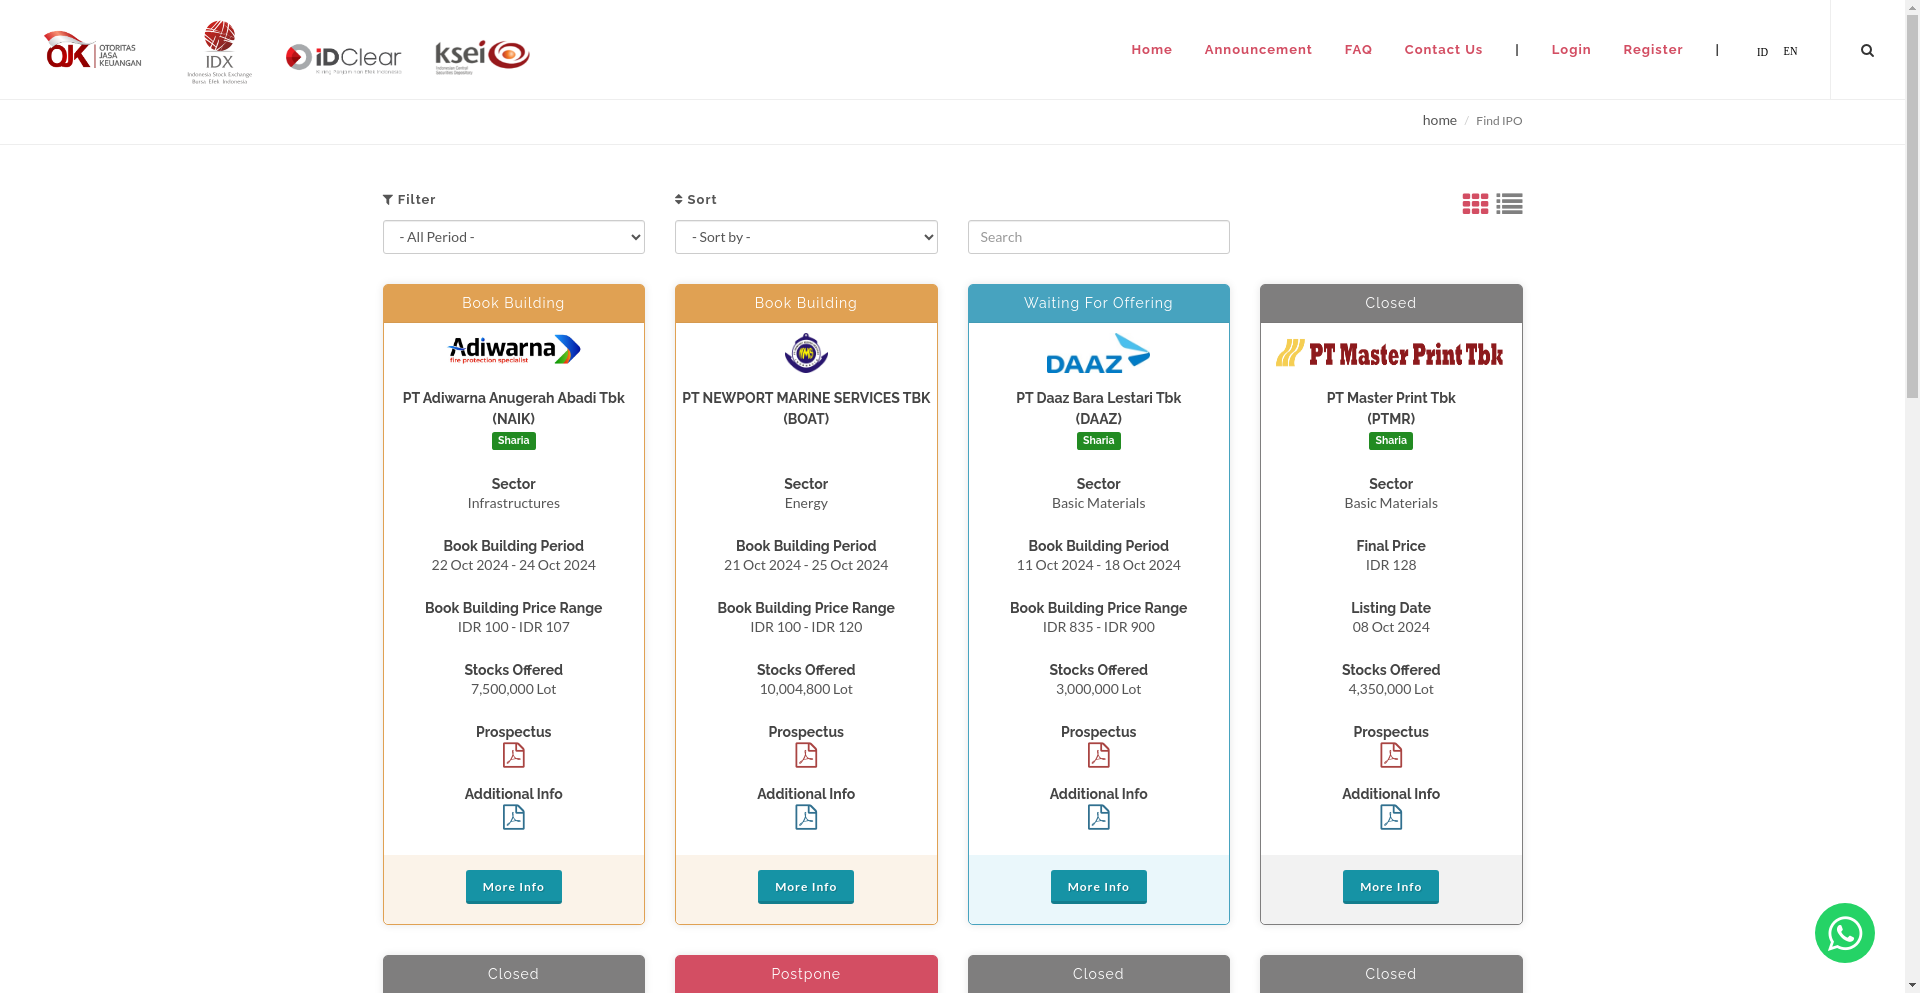

In [36]:
#Create Connection
options = uc.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')                             
options.add_argument('--disable-dev-shm-usage')
options.add_argument('user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/90.0.4430.93 Safari/537.36')
options.add_argument("--window-size=1920,1080")

driver = uc.Chrome(options=options)

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )

url = "https://www.e-ipo.co.id/en/ipo/index"
driver.get(url)

#This code will used on the next code
timeout = 10 # The process is stopped when the website does not respond within 10 seconds.
#WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.XPATH, '//*[@id="w0"]/div[2]/div[3]/ul/li[12]/a')))
#last_page = int(re.search(r'\bpage=(\d+)\b',
                  #driver.find_element(By.XPATH,'//*[@id="w0"]/div[2]/div[3]/ul/li[12]/a').get_attribute('href')).group(1))

time.sleep(3) #Wait 3 seconds for the website to display perfectly so we can get a screenshot in the next code

#Take a screenshot of the website and display it.
Image.open(BytesIO(driver.get_screenshot_as_png()))

In [37]:
def manualpass_cloudflare(driver):
    enable_cursor = """
            function enableCursor() {
              var seleniumFollowerImg = document.createElement("img");
              seleniumFollowerImg.setAttribute('src', 'data:image/png;base64,'
                + 'iVBORw0KGgoAAAANSUhEUgAAABQAAAAeCAQAAACGG/bgAAAAAmJLR0QA/4ePzL8AAAAJcEhZcwAA'
                + 'HsYAAB7GAZEt8iwAAAAHdElNRQfgAwgMIwdxU/i7AAABZklEQVQ4y43TsU4UURSH8W+XmYwkS2I0'
                + '9CRKpKGhsvIJjG9giQmliHFZlkUIGnEF7KTiCagpsYHWhoTQaiUUxLixYZb5KAAZZhbunu7O/PKf'
                + 'e+fcA+/pqwb4DuximEqXhT4iI8dMpBWEsWsuGYdpZFttiLSSgTvhZ1W/SvfO1CvYdV1kPghV68a3'
                + '0zzUWZH5pBqEui7dnqlFmLoq0gxC1XfGZdoLal2kea8ahLoqKXNAJQBT2yJzwUTVt0bS6ANqy1ga'
                + 'VCEq/oVTtjji4hQVhhnlYBH4WIJV9vlkXLm+10R8oJb79Jl1j9UdazJRGpkrmNkSF9SOz2T71s7M'
                + 'SIfD2lmmfjGSRz3hK8l4w1P+bah/HJLN0sys2JSMZQB+jKo6KSc8vLlLn5ikzF4268Wg2+pPOWW6'
                + 'ONcpr3PrXy9VfS473M/D7H+TLmrqsXtOGctvxvMv2oVNP+Av0uHbzbxyJaywyUjx8TlnPY2YxqkD'
                + 'dAAAAABJRU5ErkJggg==');
              seleniumFollowerImg.setAttribute('id', 'selenium_mouse_follower');
              seleniumFollowerImg.setAttribute('style', 'position: absolute; z-index: 99999999999; pointer-events: none; left:0; top:0');
              document.body.appendChild(seleniumFollowerImg);
              document.onmousemove = function (e) {
                document.getElementById("selenium_mouse_follower").style.left = e.pageX + 'px';
                document.getElementById("selenium_mouse_follower").style.top = e.pageY + 'px';
              };
            };

            enableCursor();
    """

    driver.execute_script(enable_cursor)

    action = webdriver.ActionChains(driver)
    action.move_by_offset(540, 300).perform()

    action.click().perform()

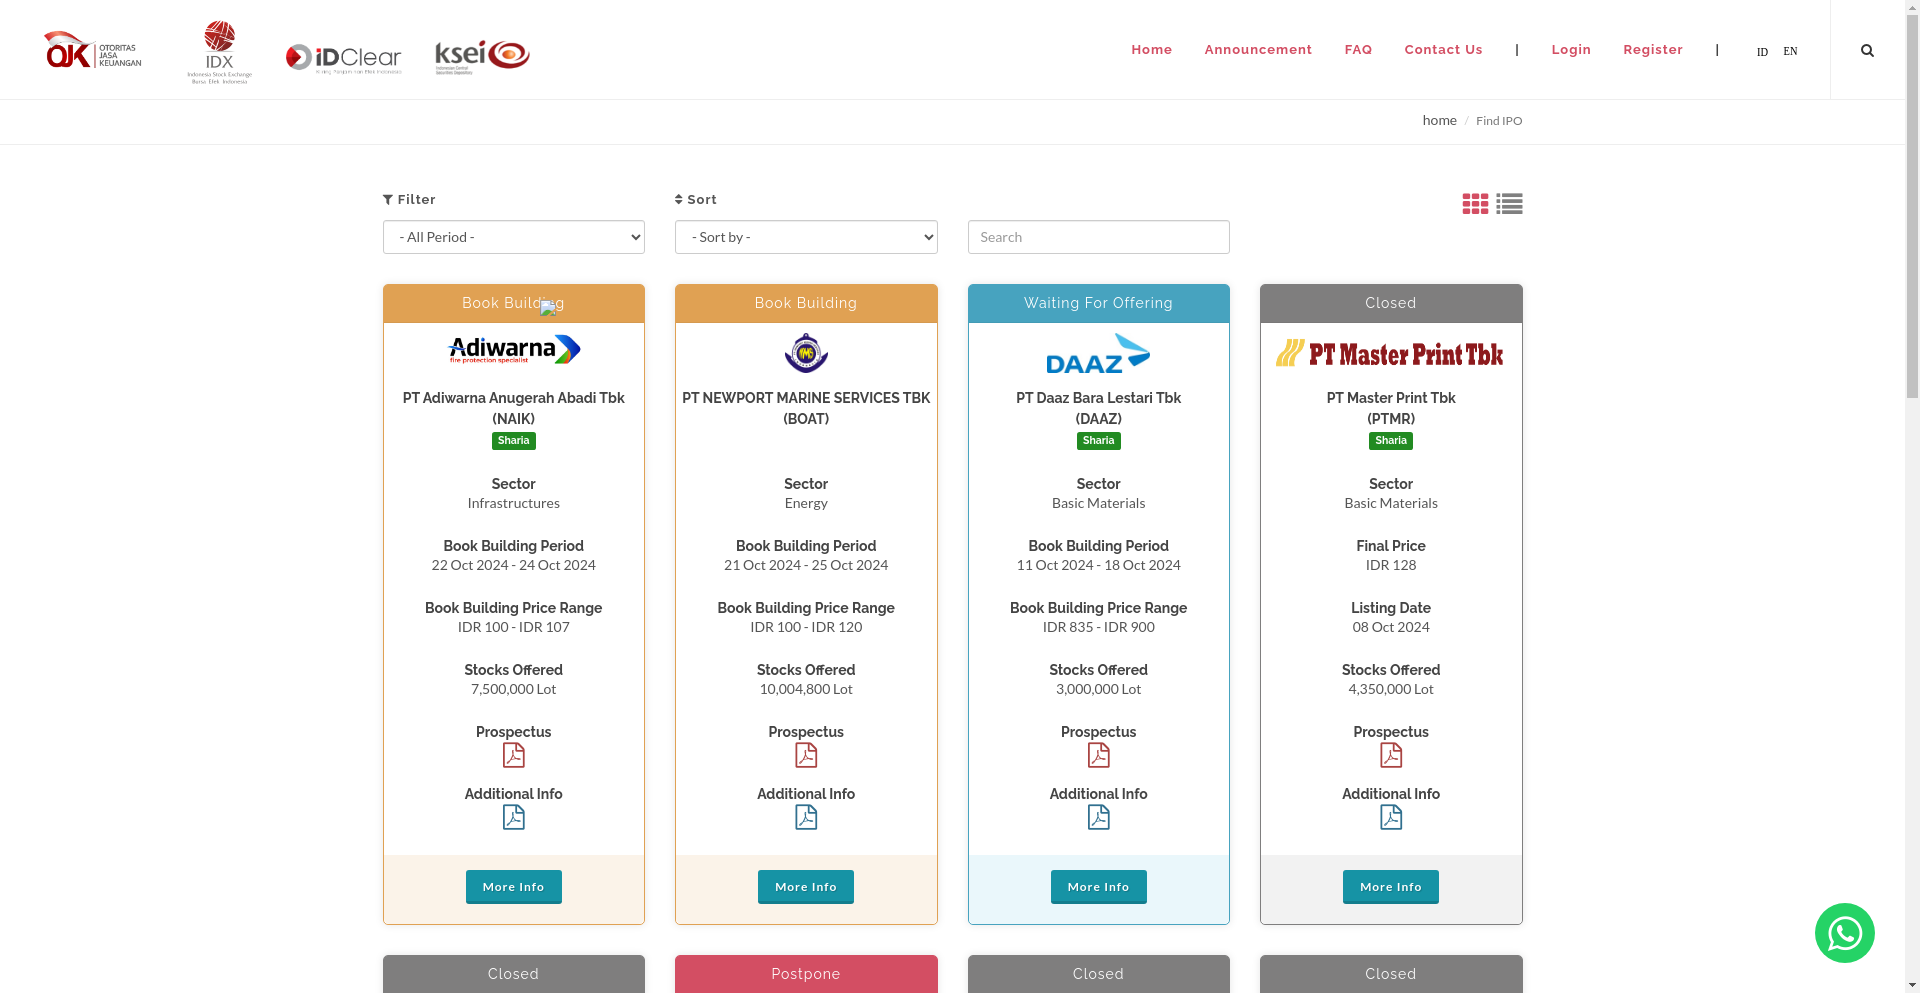

In [38]:
manualpass_cloudflare(driver)

WebDriverWait(driver, timeout=30).until(EC.presence_of_element_located((By.XPATH, '//*[@id="w0"]/div[2]/div[3]/ul/li[12]/a')))
time.sleep(3) #Wait 3 seconds for the website to display perfectly so we can get a screenshot in the next code

last_page = int(re.search(r'\bpage=(\d+)\b',
                  driver.find_element(By.XPATH,'//*[@id="w0"]/div[2]/div[3]/ul/li[12]/a').get_attribute('href')).group(1))

time.sleep(15)
#Take a screenshot of the website and display it.
Image.open(BytesIO(driver.get_screenshot_as_png()))

In [39]:
driver.quit() #close driver because this is just a test

# Breakdown Scraping Code (Scroll down to see this code)

Here, I will search for company list elements on the e-ipo website using **XPATH**. I will give an example of how to use XPATH to search for elements.<br>See this code?

    try:
        WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.XPATH, '//*[@id="w0"]/div[1]')))
        
    except TimeoutException:
        print("Timed out waiting for Response")
        break
        
In short, this code waits for a specific element specified by the XPath expression to be present on the page. This XPath expression refers to the **company list** element found on each page of the e-IPO website. If the element is found within the given timeout, the code will **continue execution**. If the element is not found, a **timeout exception will be raised**, and the code will print a message before exiting the loop.

To get the XPath code from the list company element, we can use the **Inspect Element** feature in Chrome. The following is an illustration of how I get XPath from the list company element on the e-IPO website, which is

    "//*[@id="w0"]/div[1]".

![](https://imgur.com/H0GhLga.gif)

Once the page is successfully accessed, we can retrieve the information contained in each company on the page. First, we need the link of each company. Where can we get them from? From the *More Info* element of each company. To get the link we will use XPath again. With the same steps, we get the XPath from the *More Info* element, which is

    '//*[@id="w0"]/div[1]/div[1]/div/div/div[5]/a'

![](https://imgur.com/KScrdem.gif)

After getting the XPath of the *More Info* element, we need to retrieve the link from the *href attribute* on the element with the following code

    driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div[1]/div/div/div[5]/a').get_attribute('href')

If you look at the XPath of other companies on the same page, you can see patterns in the XPath. The pattern looks like this

    '//*[@id="w0"]/div[1]/div[1]/div/div/div[5]/a'
    '//*[@id="w0"]/div[1]/div[2]/div/div/div[5]/a'
    '//*[@id="w0"]/div[1]/div[3]/div/div/div[5]/a'
    ...
    '//*[@id="w0"]/div[1]/div[12]/div/div/div[5]/a'

With this pattern, we can loop to get the information of all companies on each page. It is known that on each page there are 12 companies, so on each page we will iterate to retrieve company information **12 times**, shown with the following code:
    
    for j in range(12):
    
        try:
            link = driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[5]/a').get_attribute('href')
            
        except NoSuchElementException:
            print('Page ' + str(i) + ': Success. There is no more information')
            break

On the last page, it is possible that the list of companies is **less than or equal to 12**, so I use a break statement with the message above indicating that **no information can be retrieved from the website** because the process has reached the last page and the last company.

After we get the company link, we can access and retrieve the information on the company page. Next we will see the following code

        driver.get(link)
        
        script = """
            var element = document.getElementById("wrapper");
            var styles = window.getComputedStyle(element);
            var animationDuration = styles.animationDuration;
            var opacity = styles.opacity;
            return (animationDuration === "1.5s" && opacity === "1");
        """
        try:
            WebDriverWait(driver, timeout).until(lambda driver: driver.execute_script(script))
            data = driver.find_element(By.XPATH,'//*[@id="wrapper"]/section[2]/div/div/div[2]').text.split('\n')

        except TimeoutException:
            print("Timed out waiting for Response")
            break
            
In the code, we first access the company link. Then there is a script variable which is code in the JavaScript programming language.

This JavaScript takes the element with the ID "wrapper" and gets information related to the **animation style** and **opacity** of the element. Then, it returns true if the **animation duration is 1.5 seconds** and the **opacity is 1**. This is used as a condition to determine if the web page has fully loaded and the animation is complete before continuing the next action.

How do I know if the website loads fully when these conditions are met? We will investigate with the Inspect Element feature while we are loading the company page. Check out the following illustration

![](https://imgur.com/8oCGem3.gif)

Did you see the last update on the web page? The element with **ID "wrapper"** has a variable style with **animation duration of 1.5 seconds** and the **opacity is 1.** Therefore, we will run the next code after these conditions are met, so that the company information can be retrieved.

After that, we can get all the company information on the page by using XPath again. In the same way, we get the XPath of the element containing the company information, which is

    '//*[@id="wrapper"]/section[2]/div/div/div[2]'

![](https://imgur.com/OEspzxN.gif)

To retrieve the information we need, we can split it so that the company information will be in the form of a **list** like this

    driver.find_element(By.XPATH,'//*[@id="wrapper"]/section[2]/div/div/div[2]').text.split('\n')

and we can enter the information into the database with the *update_database* function.

**Notes**: The *update_database* function was created **specifically** for this project. If you want to retrieve information from another website, you must see how the information structure has been retrieved from the website after using the split function and after that you can retrieve information from the list using index like the *update_database* function.

After updating the database, we return to the previous page and retrieve information from the next company until the last company on that page. When the information of the last company on a page has been retrieved, then we access the next page. This step is performed until information from all companies has been retrieved.

# Scraping Code

In [40]:
#In this section, the latest data generated from this project is reused to speed up the data scraping process, by taking only changed data from the source..
#Anyway, we can disable this feature by changing the "refresh_data" variable below as TRUE.

avail_dataset = pd.read_csv("/kaggle/input/e-ipo-realtime-data/e-IPO Data.csv")
avail_dataset.drop([str(avail_dataset.columns[5])] + list(avail_dataset.columns[7:15]), axis=1, inplace=True)
avail_dataset.head()

#Refresh Data
refresh_data = False

#If "refresh_data" is set to TRUE, then the "avail_dataset" data will not be used,and the scraping process will retrieve all available data.

In [41]:
print("Data Scraping Process")

avail_dataset = pd.read_csv("/kaggle/input/e-ipo-realtime-data/e-IPO Data.csv")
avail_dataset.drop([str(avail_dataset.columns[5])] + list(avail_dataset.columns[7:15]), axis=1, inplace=True)

#Create a database in the form of a dictionary
keyList = ["IPO Status",
           "Ticker Code",
           "Company Name",
           "Sector",
           "Subsector",
           "Line of Business",
           "Address",
           "Website",
           "Number of shares offered",
           "% of Total Shares",
           "Participant Admin",
           "Underwriter(s)",
           "Book Building Period",
           "Book Building Price",
           "Offering Period",
           "Final Price (Rp)",
           "Closing Date",
           "Distribution Date",
           "Listing Date",
           "Warrant",
           "Exercise Price (Warrant) (Rp)"
          ]

database = {key: [] for key in keyList}
table = None
tickercode_list = []

#Iterations for each page
i=1 #Set i for iteration
url = "https://www.e-ipo.co.id/en/ipo/index"

#this variable will be used to limit the attempts when code scraping is run
#and if it has exceeded the attempt limit, the code is stopped and will raise an error
max_attempt = 10
attempt = 0 

start_i = 1 #i = page
start_j = 1 #j = company order on each page

timeout = 60

#Manual update e-IPO
manual_refresh = False

if not manual_refresh:
    while attempt < max_attempt:
        if attempt > 0:
            driver.quit()

        #Create Connection
        options = uc.ChromeOptions()
        options.add_argument('--headless')
        options.add_argument('--no-sandbox')                             
        options.add_argument('--disable-dev-shm-usage')
        options.add_argument('user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/90.0.4430.93 Safari/537.36')
        options.add_argument("--window-size=1920,1080")

        driver = uc.Chrome(options=options)

        stealth(driver,
                languages=["en-US", "en"],
                vendor="Google Inc.",
                platform="Win32",
                webgl_vendor="Intel Inc.",
                renderer="Intel Iris OpenGL Engine",
                fix_hairline=True,
                )

        driver.get("https://www.e-ipo.co.id/en/ipo/index")

        time.sleep(3)

        manualpass_cloudflare(driver)

        time.sleep(15)
        
        WebDriverWait(driver, timeout=60).until(EC.presence_of_element_located((By.XPATH, '//*[@id="w0"]/div[2]/div[3]/ul/li[12]/a')))

        last_page = int(re.search(r'\bpage=(\d+)\b',
                      driver.find_element(By.XPATH,'//*[@id="w0"]/div[2]/div[3]/ul/li[12]/a').get_attribute('href')).group(1))

        time.sleep(3)

        try:
            pbar_i = tqdm(range(start_i,last_page+1), desc="Pages")
            for i in pbar_i:
                driver.get("https://www.e-ipo.co.id/en/ipo/index?page=" + str(i) + "&per-page=12")

                WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.XPATH, '//*[@id="w0"]/div[1]')))

                #Iteration to retrieve information from each company that will conduct an IPO on each page.
                pbar_j = tqdm(range(start_j,13), desc=f"Companies on Page {i}", leave=False)
                for j in pbar_j:
                    #Each company's link will appear in the "link" variable
                    try:
                        WebDriverWait(driver, timeout).until(EC.text_to_be_present_in_element((By.XPATH, '//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[3]/h5'), ''))
                    except:
                        raise NoSuchElementException

                    while True:
                        try:
                            try:
                                tickercode = re.findall(r"\((.*?)\)", driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[3]/h5').text)[0]
                            except:
                                tickercode = re.findall(r"\((.*?)\)", driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[3]/h5').text)
                        except:
                            print(driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[3]/h5').text)
                            raise Exception("Ticker Code Error!")
                        if tickercode:
                            if tickercode not in tickercode_list:
                                tickercode_list.append(tickercode)
                            break
                        else:
                            continue

                    if not refresh_data:
                        if (tickercode).split('-')[0] in avail_dataset['Ticker Code'].values or tickercode in avail_dataset['Ticker Code'].values:
                            if tickercode in avail_dataset['Ticker Code'].values and str(driver.find_element(By.XPATH, '//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[1]').text) == avail_dataset.loc[avail_dataset[avail_dataset['Ticker Code'] == tickercode].index, 'IPO Status'].values[0]:
                                continue
                            else:
                                if tickercode in avail_dataset['Ticker Code']:
                                    avail_dataset.drop(avail_dataset.loc[avail_dataset['Ticker Code']==tickercode].index, inplace=True)
                                else:
                                    avail_dataset.drop(avail_dataset.loc[avail_dataset['Ticker Code']==(tickercode).split('-')[0]].index, inplace=True)

                    url = driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[5]/a').get_attribute('href')

                    #Access company links
                    driver.get(url)
                    WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.ID, "wrapper")))

                    #This script will be used in "WebDriverWait" so that the next code will run when the element with ID "wrapper"
                    #has animationDuration equal to "1.5s" and opacity equal to "1".
                    #Once the conditions are met,the Python code execution will continue.
                    script = """
                        var element = document.getElementById("wrapper");
                        var styles = window.getComputedStyle(element);
                        var animationDuration = styles.animationDuration;
                        var opacity = styles.opacity;
                        return (animationDuration === "1.5s" && opacity === "1");
                    """

                    WebDriverWait(driver, timeout).until(lambda driver: driver.execute_script(script))

                    #The company information is taken from the element in '//*[@id="wrapper"]/section[2]/div/div/div[2]'
                    #which is converted into text. Then the resulting text is converted into a list with a delimiter '\n' (New Line)
                    #and this list will be declared as a new variable called "data".
                    data = driver.find_element(By.XPATH,'//*[@id="wrapper"]/section[2]/div/div/div[2]').text.split('\n')

                    #Update the database with functions that have been created in the preparation step.
                    update_database(data)
                    start_j+=1

                    #Exit from the company page (Return to previous page)
                    url = 'https://www.e-ipo.co.id/en/ipo/index?page=' + str(i) + '&per-page=12'
                    driver.get(url)

                start_j = 1 #reset j
                start_i+=1 #update i

        except (InvalidSelectorException, NoSuchElementException):
            pbar_i.colour = "#4CAF50"
            pbar_j.colour = "#4CAF50"
            #pbar_j.n = pbar_j.total not work, fix later
            #pbar_j.update()
            #pbar_i.update(1)

            pbar_j.close() 
            pbar_i.close()
            break

        except TimeoutException:
            print(f"Error encountered. Switching to another proxy...")
            attempt += 1
            driver.quit()
            continue  # Continue to the next proxy if an error occurs

        # Break out of the loop if scraping is successful
        driver.quit()
        break

    #Add missing value on tickercode_list
    def adjust_lists(list1, list2):
        for i, item in enumerate(list1):
            if item not in list2:
                # Find the index of the item after the missing value
                next_value = list1[list1.index(item) + 1]
                # Insert the missing value before the item after it
                list2.insert(list2.index(next_value), item)
        return list2

    if not refresh_data:
        tickercode_list = adjust_lists(list(avail_dataset['Ticker Code']), tickercode_list)

    #Stores the database in the form of a dictionary into a pandas DataFrame
    if len(database['Ticker Code']):
        table = pd.DataFrame.from_dict(database)
        print(f"{len(table)} companies' data have been collected."); table
    else:
        print("There's no recent data. No company data collected.")

Data Scraping Process


Pages:   0%|          | 0/18 [00:00<?, ?it/s]

Companies on Page 1:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 2:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 3:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 4:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 5:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 6:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 7:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 8:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 9:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 10:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 11:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 12:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 13:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 14:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 15:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 16:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 17:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 18:   0%|          | 0/12 [00:00<?, ?it/s]

2 companies' data have been collected.


# Organizing Data

Currently, the data is stored in the DataFrame. For the purpose of further analysis, the data can be modified as follows:
1. Changing the columns containing date period data such as "Book Building Period" and "Offer Period" into 2 separate columns, namely the opening and closing columns.
2. Converting the Book Building Price from a range into two separate columns for the opening and closing prices.
3. Converting the price data into integer form.
4. Converting the warrant data into the form of warrant per share ratio.
5. Converting columns containing categorical data into category form and converting columns containing date data into DateTime form

**Notes:** If you want to analyze this dataset, you can run this code again because when the dataset is exported to csv, the data of type "datetime64[ns]" and "category" changes to "object".

In [42]:
if not manual_refresh:
    table = pd.DataFrame.from_dict(database); table

    if any(isinstance(i, list) for i in tickercode_list): #check if list is nested
        tickercode_list = [item for sublist in tickercode_list for item in (sublist if isinstance(sublist, list) else [sublist])] #flatting list

    if len(table):
        #Separates the column containing the range into two separate columns of opening and closing or lowest and highest.
        table[['Book Building Opening', 'Book Building Closing']] = table['Book Building Period'].str.split(' - ', expand=True)
        table.drop('Book Building Period', axis=1, inplace=True)
        table.insert(12, 'Book Building Opening', table.pop('Book Building Opening'))
        table.insert(13, 'Book Building Closing', table.pop('Book Building Closing'))

        table[['Lowest Book Building Price (Rp)', 'Highest Book Building Price (Rp)']] = table['Book Building Price'].str.split(' - ', expand=True)
        table.drop('Book Building Price', axis=1, inplace=True)
        table.insert(14, 'Lowest Book Building Price (Rp)', table.pop('Lowest Book Building Price (Rp)'))
        table.insert(15, 'Highest Book Building Price (Rp)', table.pop('Highest Book Building Price (Rp)'))

        try:
            table[['Opening of Offering Period', 'Closing of Offering Period']] = table['Offering Period'].str.split(' - ', expand=True)
        except:
            table[['Opening of Offering Period', 'Closing of Offering Period']] = None
        table.drop('Offering Period', axis=1, inplace=True)
        table.insert(16, 'Opening of Offering Period', table.pop('Opening of Offering Period'))
        table.insert(17, 'Closing of Offering Period', table.pop('Closing of Offering Period'))

        #Convert the column containing the price to an integer
        table = convert_to_integer(table, ['Lowest Book Building Price (Rp)',
                                           'Highest Book Building Price (Rp)',
                                           'Final Price (Rp)',
                                           'Exercise Price (Warrant) (Rp)'])

        #Converting warrant data into the form of warrant per share ratio
        table['Warrant'] = table['Warrant'].apply(warrant_per_share_ratio)
        table = table.rename(columns={'Warrant': 'Warrant per share ratio'})

        table.reset_index(drop=True, inplace=True)

        if refresh_data:
            pass
        else:
            table = table.reindex(columns=avail_dataset.columns)
            avail_dataset.reset_index(drop=True, inplace=True)
            table = pd.concat([table,avail_dataset], ignore_index=True)

    else:
        table = avail_dataset.copy()

    #Convert columns containing date data into DateTime form
    listdate_column = ["Book Building Opening",
                      "Book Building Closing",
                      "Opening of Offering Period",
                      "Closing of Offering Period",
                      "Closing Date",
                      "Distribution Date",
                      "Listing Date"]

    for col in listdate_column:
        table[col] = pd.to_datetime(table[col], format='mixed')
        table[col] = table[col] + pd.to_timedelta(9,"h")

    #Convert columns containing categorical data into category form
    listcategory_column = ["IPO Status",
                          "Sector",
                          "Subsector"]

    table[listcategory_column] = table[listcategory_column].apply(lambda x: x.astype('category'))

    table.drop_duplicates(subset=['Ticker Code'], keep='first', inplace=True)
    table['Ticker Code'] = pd.Categorical(table['Ticker Code'], categories=tickercode_list, ordered=True)
    table.sort_values("Ticker Code", inplace=True)
    table.reset_index(inplace=True, drop=True)
    table

In [43]:
table

,IPO Status,Ticker Code,Company Name,Sector,Subsector,Final Price (Rp),Line of Business,Address,Website,Number of shares offered,% of Total Shares,Participant Admin,Underwriter(s),Book Building Opening,Book Building Closing,Lowest Book Building Price (Rp),Highest Book Building Price (Rp),Opening of Offering Period,Closing of Offering Period,Closing Date,Distribution Date,Listing Date,Warrant per share ratio,Exercise Price (Warrant) (Rp)
0,Book Building,NAIK,PT Adiwarna Anugerah Abadi Tbk,Infrastructures,Heavy Constructions & Civil Engineering,NaN,Bergerak dalam bidang Perdagangan Sistem Prote...,Perkantoran Mutiara Taman Palem No. 53 Cengkar...,https://www.adiwarna.co.id/,750000000,23.08,EP - MNC SEKURITAS,[EP - MNC SEKURITAS],2024-10-22 09:00:00,2024-10-24 09:00:00,100,107,NaT,NaT,NaT,NaT,NaT,0.5,135.0
1,Book Building,BOAT,PT NEWPORT MARINE SERVICES TBK,Energy,"Oil, Gas & Coal Equipment & Services",NaN,Sewa dan Menyewa Kapal Untuk Menunjang Kegiata...,Thamrin Residences - Office Park Unit C18 Tham...,https://nms-ina.com/,1000480000,28.57,OD - BRI DANAREKSA SEKURITAS,[OD - BRI DANAREKSA SEKURITAS],2024-10-21 09:00:00,2024-10-25 09:00:00,100,120,NaT,NaT,NaT,NaT,NaT,0.0,<NA>
2,Waiting For Offering,DAAZ,PT Daaz Bara Lestari Tbk,Basic Materials,Diversified Metals & Minerals,NaN,"Perdagangan besar logam dan bijih logam, dan a...","Gedung Office 8, SCBD Lot 28, Lantai 21 Unit E...",https://www.daaz-group.com,300000000,15.02,HP - HENAN PUTIHRAI SEKURITAS,['HP - HENAN PUTIHRAI SEKURITAS'],2024-10-11 09:00:00,2024-10-18 09:00:00,835,900,NaT,NaT,NaT,NaT,NaT,0.0,<NA>
3,Closed,PTMR,PT Master Print Tbk,Basic Materials,Containers & Packaging,128.0,Bergerak dalam bidang perdagangan sebagai dist...,NaN,https://www.masterprint.co.id,435000000,22.81,RG - PROFINDO SEKURITAS INDONESIA,['RG - PROFINDO SEKURITAS INDONESIA'],2024-09-20 09:00:00,2024-09-24 09:00:00,125,135,2024-10-02 09:00:00,2024-10-04 09:00:00,2024-10-04 09:00:00,2024-10-07 09:00:00,2024-10-08 09:00:00,0.0,<NA>
4,Closed,VERN,PT Verona Indah Pictures Tbk,Consumer Cyclicals,Entertainment & Movie Production,195.0,"Aktivitas Produksi, Pasca Produksi, serta Dist...","Graha Arteri Mas , Jalan Panjang No.68, Kav.38...",https://www.veronapictures.co.id/,1121650000,23.54,AI - UOB KAY HIAN SEKURITAS,['AI - UOB KAY HIAN SEKURITAS'],2024-09-18 09:00:00,2024-09-25 09:00:00,190,195,2024-10-02 09:00:00,2024-10-04 09:00:00,2024-10-04 09:00:00,2024-10-07 09:00:00,2024-10-08 09:00:00,0.5,216.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Closed,BMHS,PT Bundamedik Tbk,Healthcare,Healthcare Providers,340.0,Bergerak di bidang aktivitas rumah sakit swast...,"Jl. Teuku Cik Ditiro No. 28, Menteng Jakarta 1...",https://www.bmhs.co.id,620000000,7.00,KI - CIPTADANA SEKURITAS ASIA,['KI - CIPTADANA SEKURITAS ASIA'],2021-06-17 09:00:00,2021-06-22 09:00:00,300,350,2021-06-30 09:00:00,2021-07-02 09:00:00,2021-07-02 09:00:00,2021-07-05 09:00:00,2021-07-06 09:00:00,0.0,<NA>
212,Closed,MASB,PT Bank Multiarta Sentosa Tbk,Financials,Banks,3360.0,Bank,NaN,https://www.bankmas.co.id,186176500,15.00,SQ - BCA SEKURITAS,['SQ - BCA SEKURITAS'],2021-06-07 09:00:00,2021-06-15 09:00:00,3000,4000,2021-06-24 09:00:00,2021-06-28 09:00:00,2021-06-28 09:00:00,2021-06-29 09:00:00,2021-06-30 09:00:00,1.0,3500.0
213,Closed,ARCI,PT Archi Indonesia Tbk,Basic Materials,Gold,750.0,Perusahaan holding di bidang pertambangan mine...,"Menara Rajawali, Lantai 19, Jl. DR Ide Anak Ag...",https://www.archiindonesia.com,3725250000,15.00,AI - UOB KAY HIAN SEKURITAS,"['AI - UOB KAY HIAN SEKURITAS', 'CC - MANDIRI ...",2021-05-31 09:00:00,2021-06-09 09:00:00,750,800,2021-06-22 09:00:00,2021-06-24 09:00:00,2021-06-24 09:00:00,2021-06-25 09:00:00,2021-06-28 09:00:00,0.0,<NA>
214,Closed,UNIQ,PT Ulima Nitra Tbk,Energy,"Oil, Gas & Coal Equipment & Services",118.0,Jasa Pertambangan dan Jasa Sewa Menyewa Perala...,"JL. Betet No. 28 RT 22/ RW 9, 9 Ilir, Ilir Tim...",https://www.ulimanitra.co.id,3000000

# Collect Listing Board Classification

In [44]:
board = pd.read_excel("/kaggle/input/listing-board-idx/NewListing-All.xlsx")
board = board[["Kode ","Papan Pencatatan"]]
board.rename(columns={"Kode ":"Ticker Code","Papan Pencatatan":"Listing Board"}, inplace=True)
board.head()

,Ticker Code,Listing Board
0,NEST,Pengembangan
1,DOSS,Pengembangan
2,LABS,Pengembangan
3,GUNA,Pengembangan
4,GOLF,Utama


In [45]:
if not manual_refresh:
    table = pd.merge(table,board,on = "Ticker Code",how = "left")
    table

# Collect Stock Returns Data

To fulfill the needs of return analysis on e-IPO stocks, close price data on each stock is taken from **Yahoo! Finance** using the **yfinance** package which is then processed into return data. Here I create some functions to help with data processing.

**Notes:** The return data taken is the first **7 days return data** because the current e-IPO trend only focuses on the early days of the stock when it starts listing on the stock exchange. Then I also took the return data since the company was listed on the stock exchange until now called **"Return from Listing Date"**.

In [46]:
def get_closing_price(stock_symbol, pandas_date):
    max_attempt=10
    attempt=0
    while attempt<max_attempt:
        try:
            close = yf.download(stock_symbol,
                            period='1d',
                            start=pandas_date,
                            end=pandas_date + pd.to_timedelta(30,'d'),
                            progress=False)['Close']
            break
        except:
            attempt+=1
            continue
            
    if close.empty:
        return [None]
    else:
        return [item for sublist in close.iloc[0:7].values.tolist() for item in sublist]
    
def close_to_return(lst):
    if None in lst:
        return None
    else:
        return [(lst[i] - lst[i-1]) / lst[i-1] for i in range(1, len(lst))]

In the code below, the data gathering process from Yahoo Finance starts and the return data will be inserted into the main dataframe.

In [47]:
if not manual_refresh:
    keyList_return = ["Return D1",
                      "Return D2",
                      "Return D3",
                      "Return D4",
                      "Return D5",
                      "Return D6",
                      "Return D7"
                     ]

    database_return = {key: [] for key in keyList_return}

    bar_return = tqdm(range(len(table)), desc="First week Return for Company")
    try:
        for bar_return, ticker, final, listing in zip(bar_return, table["Ticker Code"], table["Final Price (Rp)"], table["Listing Date"]):
            return_data = close_to_return([final] + get_closing_price(ticker+".JK", listing))

            if return_data is None:
                return_data = [None]*7
            else:
                diff_len = 7 - len(return_data)
                return_data = return_data + [None]*diff_len

            #Update
            for key, return_value in zip(database_return.keys(), return_data):
                database_return[key].append(return_value)

    except TypeError:
        print(ticker) #for troubleshooting
        raise Exception("Process Stopped")

    #Updating Main DataFrame
    table[["Return D1","Return D2","Return D3","Return D4","Return D5","Return D6","Return D7"]] = pd.DataFrame.from_dict(database_return)

    database_returnListingDate = []

    bar_return_listingdate = tqdm(range(len(table)), desc="Return from listing date for Company")
    for bar_return, ticker, final, listing in zip(bar_return_listingdate, table["Ticker Code"], table["Final Price (Rp)"], table["Listing Date"]):
        try:
            return_ListingDate = (yf.Ticker(ticker+".JK").history()['Close'][-1] - final) / final
        except:
            return_ListingDate = np.nan

        database_returnListingDate.append(return_ListingDate)

    #Updating Main DataFrame
    table["Return from Listing Date"] = pd.DataFrame.from_dict(database_returnListingDate)

    # Rearrange Columns
    #table = pd.concat([table.loc[:, 'IPO Status':'Subsector'], table.loc[:, 'Listing Board':], table.loc[:, 'Line of Business':'Exercise Price (Warrant) (Rp)']], axis=1)
    table = pd.concat([table.loc[:, 'IPO Status':'Subsector'],
                       table.loc[:, 'Listing Board'],
                       table.loc[:, 'Final Price (Rp)'],
                       table.loc[:, 'Return D1':],
                       table.loc[:, 'Line of Business':'Closing of Offering Period'],
                       table.loc[:, 'Closing Date':'Exercise Price (Warrant) (Rp)']],
                      axis=1)

    # Display DataFrame
    table.head()
    #View the data type of each column in the DataFrame
    len(table.columns), table.dtypes

First week Return for Company:   0%|          | 0/216 [00:00<?, ?it/s]

Return from listing date for Company:   0%|          | 0/216 [00:00<?, ?it/s]

# Warrant Data Frame

In [48]:
tv = TvDatafeed()

In [49]:
warrant_key = ["Open",
                "High",
                "Low",
                "Close",
               "Ticker Code"
               ]

warrant_database = {key: [] for key in warrant_key}

if not manual_refresh:
    for index,row in tqdm(table[['Ticker Code','Warrant per share ratio']].iterrows(), total=table.shape[0]):
        if row[1]!=0:
            try:
                data_w = tv.get_hist(symbol=row[0]+'.W',exchange='IDX',interval=Interval.in_daily,n_bars=1000).iloc[0].iloc[1:5]
                data_w["Ticker Code"]=row[0]
                for key, value in zip(warrant_database.keys(),data_w):
                    warrant_database[key].append(value)
            except:
                for key, value in zip(warrant_database.keys(), ["-","-","-","-",row[0]]):
                    warrant_database[key].append(value)
                    
    warrant_df = None
    warrant_df = pd.merge(table[['Ticker Code',
                                   'Participant Admin',
                                   'Underwriter(s)',
                                   'Listing Board',
                                   'Final Price (Rp)',
                                   'Warrant per share ratio',
                                   'Exercise Price (Warrant) (Rp)']],
                            pd.DataFrame.from_dict(warrant_database),
                          on="Ticker Code")

    warrant_df['Ticker Code'] = warrant_df['Ticker Code'].apply(lambda x: x+"-W"); warrant_df

  0%|          | 0/216 [00:00<?, ?it/s]

# Closing

The data has been collected and is ready to be exported into CSV and updated to google spreadsheet as well.

In [50]:
#Manual Refresh   
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%d %B %Y')

#Convert columns containing date data into DateTime form
listdate_column = ["Book Building Opening",
                  "Book Building Closing",
                  "Opening of Offering Period",
                  "Closing of Offering Period",
                  "Closing Date",
                  "Distribution Date",
                  "Listing Date"]

if manual_refresh:
    import pandas as pd
    table = pd.read_csv('/kaggle/input/manual-update-e-ipo/e-IPO Data.csv', sep=';', parse_dates=listdate_column, decimal=",")
    warrant_df = pd.read_csv('/kaggle/input/manual-update-e-ipo/Warrant - Price D1.csv')

In [51]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   IPO Status                        216 non-null    category      
 1   Ticker Code                       216 non-null    object        
 2   Company Name                      216 non-null    object        
 3   Sector                            215 non-null    category      
 4   Subsector                         212 non-null    category      
 5   Listing Board                     198 non-null    object        
 6   Final Price (Rp)                  205 non-null    float64       
 7   Return D1                         204 non-null    float64       
 8   Return D2                         204 non-null    float64       
 9   Return D3                         204 non-null    float64       
 10  Return D4                         204 non-null    

In [52]:
#Save DataFrame to CSV
table.to_csv("e-IPO Data.csv",
             date_format='%Y-%m-%d',
             index=False)

warrant_df.to_csv("Warrant - Price D1.csv",
             date_format='%Y-%m-%d',
             index=False)

#Save DataFrame to Google Spreadsheets
credential = ServiceAccountCredentials.from_json_keyfile_dict(json.loads(UserSecretsClient().get_secret("mycredential")))
gc = gspread.authorize(credential)

spreadsheet = gc.open_by_url(UserSecretsClient().get_secret("spreadsheet_link"))
set_with_dataframe(spreadsheet.worksheet('Dataset'), table)
set_with_dataframe(spreadsheet.worksheet('Data Waran D1'), warrant_df)


spreadsheet = gc.open_by_url(UserSecretsClient().get_secret("spreadsheet_link_USERS"))
set_with_dataframe(spreadsheet.worksheet('Dataset'), table)

I am open to any feedback and suggestions on this notebook, so that I can improve and make better projects. Thank you.

# Dataset

The data collected from this web scraping project will be available in the following kaggle dataset<br>
https://www.kaggle.com/datasets/fahmirk/e-ipo-realtime-data

Data is updated daily using the schedule run feature.